# 7.8 Lab: Non-linear Modeling 

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pandas as pd 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm
from patsy import dmatrix

%matplotlib inline
import seaborn as sns
sns.set_theme()
sns.set_style("ticks")

In [3]:
# in this lab, we will use Wage data. Let us read in the CSV data ans look at a sample of this data.
Wage = pd.read_csv('https://raw.githubusercontent.com/tvanzyl/Sharing_ISL_python/master/data/Wage.csv', header=0, na_values='NA')
print(Wage.shape)
print(Wage.head())

(3000, 12)
   year  age      sex            maritl      race        education  \
0  2006   18  1. Male  1. Never Married  1. White     1. < HS Grad   
1  2004   24  1. Male  1. Never Married  1. White  4. College Grad   
2  2003   45  1. Male        2. Married  1. White  3. Some College   
3  2003   43  1. Male        2. Married  3. Asian  4. College Grad   
4  2005   50  1. Male       4. Divorced  1. White       2. HS Grad   

               region        jobclass          health health_ins   logwage  \
0  2. Middle Atlantic   1. Industrial       1. <=Good      2. No  4.318063   
1  2. Middle Atlantic  2. Information  2. >=Very Good      2. No  4.255273   
2  2. Middle Atlantic   1. Industrial       1. <=Good     1. Yes  4.875061   
3  2. Middle Atlantic  2. Information  2. >=Very Good     1. Yes  5.041393   
4  2. Middle Atlantic  2. Information       1. <=Good     1. Yes  4.318063   

         wage  
0   75.043154  
1   70.476020  
2  130.982177  
3  154.685293  
4   75.043154  


## 7.8.1 Polynomial Regression and Step Functions

In [4]:
"""
We will examine how to fit a polynomial regression model on the wage dataset. As all the techniques, 
we have multiple ways to do this. Here I will use sklearn as we alreadly used statsmodel.api before in Chapter 3. 
If you are looking for more built-in functions around p-value, significance, confidence intervie, etc., 
I would recommend to use statsmodel.api. 

But scikit-learn does not have built error estimates for doing inference. But this problem forces us to 
think about a more general method to find Confidence Interview (key word: Bootstrap) 

Numpy also has a nice function to do ploynomial regression: https://www.ritchieng.com/machine-learning-polynomial-regression/
"""

n_deg = 4
X = Wage.age
y = Wage.wage
X = X.values.reshape(X.shape[0], 1)
y = y.values.reshape(y.shape[0], 1)

polynomial_features= PolynomialFeatures(degree=n_deg)
X_poly = polynomial_features.fit_transform(X)

reg = LinearRegression()
reg.fit(X_poly, y)

# get coefficients and compare with the numbers 
print(reg.intercept_)
print(reg.coef_)

[-184.15417976]
[[ 0.00000000e+00  2.12455205e+01 -5.63859313e-01  6.81068771e-03
  -3.20383038e-05]]


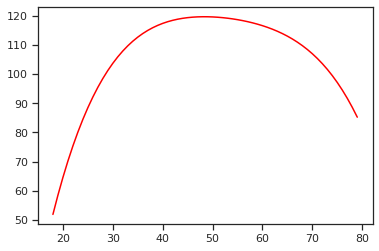

In [5]:
# we now create a grid of values for age at which we want predictionsm and the call the generic predict() function 
# generate a sequence of age values spanning the range
age_grid = np.arange(Wage.age.min(), Wage.age.max()).reshape(-1,1)

# generate test data use PolynomialFeatures and fit_transform
X_test = PolynomialFeatures(degree=n_deg).fit_transform(age_grid)

# predict the value of the generated ages
y_pred = reg.predict(X_test)

# creating plots
plt.plot(age_grid, y_pred, color='red')
plt.show()

In [6]:
"""
Next we need to decide the order of the polynomial.
In the book, the authors did this by using hypothesis testing.  ANOVA using F-test was explanied. 
In order to use the ANOVA function, two models $M_1$ and $M_2$ must be nested model: 
the predictors in $M_1$ must be a subset of the predictors in $M_2$. 
statsmodel.api has a nice built-in function to do that. 

As an alternative, we could choose the polynomial degree using cross-validation, as discussed in before. 
Actually, the cross-validation approach is more commonly used in practice. 
"""

X1 = PolynomialFeatures(1).fit_transform(X)
X2 = PolynomialFeatures(2).fit_transform(X)
X3 = PolynomialFeatures(3).fit_transform(X)
X4 = PolynomialFeatures(4).fit_transform(X)
X5 = PolynomialFeatures(5).fit_transform(X)
fit1 = sm.GLS(y, X1).fit()
fit2 = sm.GLS(y, X2).fit()
fit3 = sm.GLS(y, X3).fit()
fit4 = sm.GLS(y, X4).fit()
fit5 = sm.GLS(y, X5).fit()

In [7]:
print(sm.stats.anova_lm(fit1, fit2, fit3, fit4, fit5, type=1))

"""
The above table, we fit five different models and sequentially compare the simpler model to the more complex model.
The summary above shows the quadratic model fit2 is significantly better than fit1 at p value of $2.36*10^{-32}$.
Similarly, the cubic model is significnatly better than the quadratic model ($p = 1.68 * 10^{-3}$).
The p-value comparing the cubic and degree-4 polynomials, fit3 and fit4, is approximately 0.05 
while the degree-5 polynomial fit5 seems unnecessary because its p-value is 0.37. 
Hence, either a cubic or a quartic polynomial appear to provide a reasonable fit to the data, 
but lower- or higher-order models are not justified.
"""

   df_resid           ssr  df_diff        ss_diff           F        Pr(>F)
0    2998.0  5.022216e+06      0.0            NaN         NaN           NaN
1    2997.0  4.793430e+06      1.0  228786.010128  143.593107  2.363850e-32
2    2996.0  4.777674e+06      1.0   15755.693664    9.888756  1.679202e-03
3    2995.0  4.771604e+06      1.0    6070.152124    3.809813  5.104620e-02
4    2994.0  4.770322e+06      1.0    1282.563017    0.804976  3.696820e-01


'\nThe above table, we fit five different models and sequentially compare the simpler model to the more complex model.\nThe summary above shows the quadratic model fit2 is significantly better than fit1 at p value of $2.36*10^{-32}$.\nSimilarly, the cubic model is significnatly better than the quadratic model ($p = 1.68 * 10^{-3}$).\nThe p-value comparing the cubic and degree-4 polynomials, fit3 and fit4, is approximately 0.05 \nwhile the degree-5 polynomial fit5 seems unnecessary because its p-value is 0.37. \nHence, either a cubic or a quartic polynomial appear to provide a reasonable fit to the data, \nbut lower- or higher-order models are not justified.\n'

In [8]:
# in the book, the authors also discussed logistic regression and the polynomial terms. 
# in python, sm.GLM function provided some functions similar to glm() in R.
logistic_model = sm.GLM ((y>250), X4, family=sm.families.Binomial())
logistic_fit = logistic_model.fit()
print(logistic_fit.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 3000
Model:                            GLM   Df Residuals:                     2995
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -350.61
Date:                Fri, 07 Oct 2022   Deviance:                       701.22
Time:                        08:18:55   Pearson chi2:                 3.70e+03
No. Iterations:                    10   Pseudo R-squ. (CS):           0.009724
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -109.5530     47.655     -2.299      0.0

In [9]:
# in python, we could use the pd.cut() function to fit a step function.
age_cut, bins = pd.cut(Wage.age, bins=4, retbins=True, right=True)
age_cut.value_counts(sort=False)

""" 
Here cut() automatically picked the cutpoints at 33.5, 49, and 64.5 years of age. 
We could also have specified our own cutpoints directly using the breaks option (set bins into a sequence of scalars, e.g. [0, 10, 20, 40, 100]). 
Note in the following code, I manually added a constant column and dropped the lowest value bin (17.938, 33.5] dummy variable.
"""

' \nHere cut() automatically picked the cutpoints at 33.5, 49, and 64.5 years of age. \nWe could also have specified our own cutpoints directly using the breaks option (set bins into a sequence of scalars, e.g. [0, 10, 20, 40, 100]). \nNote in the following code, I manually added a constant column and dropped the lowest value bin (17.938, 33.5] dummy variable.\n'

In [10]:
age_cut_dummies = pd.get_dummies(age_cut)
age_cut_dummies = sm.add_constant(age_cut_dummies)
fit_age_cut = sm.GLM(Wage.wage, age_cut_dummies.drop(age_cut_dummies.columns[1], axis=1)).fit()
print(fit_age_cut.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   wage   No. Observations:                 3000
Model:                            GLM   Df Residuals:                     2996
Model Family:                Gaussian   Df Model:                            3
Link Function:               identity   Scale:                          1634.1
Method:                          IRLS   Log-Likelihood:                -15353.
Date:                Fri, 07 Oct 2022   Deviance:                   4.8957e+06
Time:                        08:18:56   Pearson chi2:                 4.90e+06
No. Iterations:                     3   Pseudo R-squ. (CS):            0.06441
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           94.1584      1.476     63.790   

## 7.8.2 Splines

In [11]:
# in order to fit regression splines in python, we use the spatsy library. 
# from patsy import dmatrix

""" 
In the content of section 7.4, we saw that regression splines can be fit by constructing an appropriate matrix of basis functions. 
The bs() function generates the entire matrix of bs() basis functions for splines with the specified set of knots. 
By default, cubic splines are produced. Here we have prespecified knots at ages 25, 40, and 60. 
This produces a spline with six basis functions. 
"""
age_grid = np.arange(Wage.age.min(), Wage.age.max()).reshape(-1,1)
spline_basis1 = dmatrix("bs(Wage.age, knots=(25,40,60), degree=3, include_intercept=False)", {"Wage.age": Wage.age}, return_type='dataframe')

In [12]:
# now we can fit the model using the spline basis functions
spline_fit1 = sm.GLM(Wage.wage, spline_basis1).fit()
spline_fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                   wage   No. Observations:                 3000
Model:                            GLM   Df Residuals:                     2993
Model Family:                Gaussian   Df Model:                            6
Link Function:               identity   Scale:                          1594.0
Method:                          IRLS   Log-Likelihood:                -15314.
Date:                Fri, 07 Oct 2022   Deviance:                   4.7708e+06
Time:                        08:18:56   Pearson chi2:                 4.77e+06
No. Iterations:                     3   Pseudo R-squ. (CS):            0.09006
Covariance Type:            nonrobust                                         
==========================================================================================================================================
                                                                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                 60.4937      9.460      6.394      0.000      41.952      79.036
bs(Wage.age, knots=(25, 40, 60), degree=3, include_intercept=False)[0]     3.9805     12.538      0.317      0.751     -20.593      28.554
bs(Wage.age, knots=(25, 40, 60), degree=3, include_intercept=False)[1]    44.6310      9.626      4.636      0.000      25.764      63.498
bs(Wage.age, knots=(25, 40, 60), degree=3, include_intercept=False)[2]    62.8388     10.755      5.843      0.000      41.759      83.919
bs(Wage.age, knots=(25, 40, 60), degree=3, include_intercept=False)[3]    55.9908     10.706      5.230      0.000      35.007      76.975
bs(Wage.age, knots=(25, 40, 60), degree=3, include_intercept=False)[4]    50.6881     14.402      3.520      0.000      22.461      78.915
bs(Wage.age, knots=(25, 40, 60), degree=3, include_intercept=False)[5]    16.6061     19.126      0.868      0.385     -20.881      54.093
==========================================================================================================================================
"""

In [13]:
# another approach is to fix the degree of freedom and let the code to automatically choose the knots.
spline_basis2 = dmatrix("bs(Wage.age, df=6, include_intercept=False)",
                        {"Wage.age": Wage.age}, return_type='dataframe')
spline_fit2 = sm.GLM(Wage.wage, spline_basis2).fit()
spline_fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                   wage   No. Observations:                 3000
Model:                            GLM   Df Residuals:                     2993
Model Family:                Gaussian   Df Model:                            6
Link Function:               identity   Scale:                          1592.5
Method:                          IRLS   Log-Likelihood:                -15313.
Date:                Fri, 07 Oct 2022   Deviance:                   4.7662e+06
Time:                        08:18:56   Pearson chi2:                 4.77e+06
No. Iterations:                     3   Pseudo R-squ. (CS):            0.09101
Covariance Type:            nonrobust                                         
==================================================================================================================
                                                     coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
Intercept                                         56.3138      7.258      7.759      0.000      42.088      70.539
bs(Wage.age, df=6, include_intercept=False)[0]    27.8240     12.435      2.238      0.025       3.453      52.195
bs(Wage.age, df=6, include_intercept=False)[1]    54.0625      7.127      7.585      0.000      40.093      68.032
bs(Wage.age, df=6, include_intercept=False)[2]    65.8284      8.323      7.909      0.000      49.515      82.142
bs(Wage.age, df=6, include_intercept=False)[3]    55.8127      8.724      6.398      0.000      38.714      72.911
bs(Wage.age, df=6, include_intercept=False)[4]    72.1315     13.745      5.248      0.000      45.192      99.071
bs(Wage.age, df=6, include_intercept=False)[5]    14.7509     16.209      0.910      0.363     -17.018      46.519
==================================================================================================================
"""

In [14]:
# package patsy also has a nice function to do natural spline using cr()
spline_basis3 = dmatrix("cr(Wage.age, df=4)", {"Wage.age": Wage.age}, return_type='dataframe')
spline_fit3 = sm.GLM(Wage.wage, spline_basis3).fit()
spline_fit3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                   wage   No. Observations:                 3000
Model:                            GLM   Df Residuals:                     2996
Model Family:                Gaussian   Df Model:                            3
Link Function:               identity   Scale:                          1596.4
Method:                          IRLS   Log-Likelihood:                -15318.
Date:                Fri, 07 Oct 2022   Deviance:                   4.7827e+06
Time:                        08:18:56   Pearson chi2:                 4.78e+06
No. Iterations:                     3   Pseudo R-squ. (CS):            0.08766
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                79.6421      1.773     44.918      0.000      76.167      83.117
cr(Wage.age, df=4)[0]   -14.6678      3.436     -4.269      0.000     -21.402      -7.934
cr(Wage.age, df=4)[1]    36.8111      1.950     18.881      0.000      32.990      40.632
cr(Wage.age, df=4)[2]    35.9349      2.056     17.476      0.000      31.905      39.965
cr(Wage.age, df=4)[3]    21.5639      6.989      3.085      0.002       7.865      35.263
=========================================================================================
"""

In [15]:
# finally, let us make some predictions
pred1 = spline_fit1.predict(dmatrix("bs(age_grid, knots=(25,40,60), include_intercept=False)",{"age_grid": age_grid}, return_type='dataframe'))
pred2 = spline_fit2.predict(dmatrix("bs(age_grid, df=6, include_intercept=False)",{"age_grid": age_grid}, return_type='dataframe'))
pred3 = spline_fit3.predict(dmatrix("cr(age_grid, df=4)", {"age_grid": age_grid}, return_type='dataframe'))

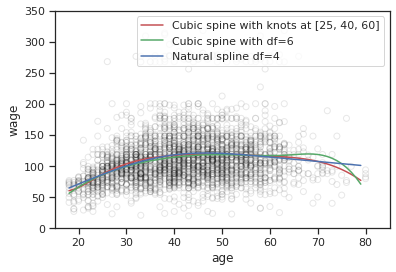

In [16]:
# plot the splines and error bands
plt.scatter(Wage.age, Wage.wage, facecolor='None', edgecolor='k', alpha=0.1)
plt.plot(age_grid, pred1, color='r', label='Cubic spine with knots at [25, 40, 60]')
plt.plot(age_grid, pred2, color='g', label='Cubic spine with df=6')
plt.plot(age_grid, pred3, color='b', label='Natural spline df=4')
plt.legend()
plt.xlim(15,85)
plt.ylim(0,350)
plt.xlabel('age')
plt.ylabel('wage')
plt.show()

## 7.8.3 GAMs

In [17]:
# we now fit a GAM to predict wage using natural spline functions of year and age, treating education as a qualitative (i.e. categorical) predictor.
age_basis = dmatrix("cr(Wage.age, df=5)", {"Wage.age": Wage.age}, return_type='dataframe')
year_basis = dmatrix("cr(Wage.year, df=4)", {"Wage.year": Wage.year}, return_type='dataframe').drop (['Intercept'], axis = 1)
education_dummies = pd.get_dummies(Wage.education)
education_dummies = education_dummies.drop([education_dummies.columns[0]], axis = 1)

# we concatenate all the predictors
x_all = pd.concat([age_basis, year_basis, education_dummies], axis=1)

In [18]:
# fit a model and print the summary
gam1_fit = sm.OLS(Wage.wage, x_all).fit()
print(gam1_fit.summary())

""" 
We could apply similar analysis procedure to this analysis, 
such as ANOVA, construction of a classification model and visually inspecting the model performance.
"""

                            OLS Regression Results                            
Dep. Variable:                   wage   R-squared:                       0.292
Model:                            OLS   Adj. R-squared:                  0.289
Method:                 Least Squares   F-statistic:                     111.8
Date:                Fri, 07 Oct 2022   Prob (F-statistic):          2.63e-214
Time:                        08:18:58   Log-Likelihood:                -14933.
No. Observations:                3000   AIC:                         2.989e+04
Df Residuals:                    2988   BIC:                         2.996e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 52

' \nWe could apply similar analysis procedure to this analysis, \nsuch as ANOVA, construction of a classification model and visually inspecting the model performance.\n'

In [19]:
# End of Chapter 7